### <b>Table of Content</b>

0. Import functions

1. Load data

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [1]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float

### <b>1. Load data</b>

In [2]:
# Details of the source file in G Drive
base_url = "https://drive.google.com/file/d/"
file_id = "1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk"
file_url = f"{base_url}{file_id}"
file_name = "2020Q1Q2Q3Q4-2021Q1.xlsx"

# Manually define sheet names as xlsx files have a 31-character limitation on sheet names.
full_sheet_names = [
    "Russia - Sberbank Rossii PAO (SBER)",
    "Turkey - Koc Holding AS (KCHOL)",
    "Egypt - Medinet Nasr Housing (MNHD)",
    "Brazil - Minerva SA/Brazil (BEEF3)",
    "Argentina - Pampa Energia SA (PAMP)",
    "Colombia - Cementos Argos SA (CCB)",
    "South Africa - Impala Platinum Holdings Ltd (IMPJ)",
    "South Korea - Dongkuk Steel Mill Co Ltd (001230)"
]

# Details of local directories
root_dir = sys.path[0]
download_dir = Path(root_dir) / "data"
file_path = download_dir / file_name

if os.path.exists(file_path):
    print(f"File {file_name} already exists in {download_dir}.")
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f"File {file_name} is not found in {download_dir}.")
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in c:\Users\Admin\Documents\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


In [3]:
data_dfs = load_dataframes(file_path, full_sheet_names)
print(f"{len(data_dfs)} DataFrames loaded with the following sheet names:\n")
for sheet_name in full_sheet_names:
    print(sheet_name)

print("\n\nBasic info of the first DateFrame:\n")
print(data_dfs[full_sheet_names[0]].info())

print("\n\nTail of the first DataFrame:")
data_dfs[full_sheet_names[0]].tail()

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Ta

,Date,Price,Open,High,Low,Vol.,Change %
306,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.0008
307,2020-01-09,257.99,259.40,261.76,257.01,38.33M,-0.0045
308,2020-01-08,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06,253.90,254.75,254.84,251.40,22.35M,-0.0043
310,2020-01-03,255.00,255.99,258.19,253.70,35.85M,0.0010


Convert the Vol. column from string (object) to float so that it can be fed into a regression model.

Also, only select rows where date is in 2020 as training data and rows in 2021 as test date.

In [4]:
train_dfs = {}
for name, df in data_dfs.items():
    df_copy = df.copy()
    df_copy['Vol.'] = df_copy['Vol.'].apply(convert_vol_to_float)
    train_df = df_copy[df_copy['Date'].dt.year == 2020]\
            .set_index('Date').sort_index()\
            .rename(columns={'Price': 'Close'})
    test_df = df_copy[df_copy['Date'].dt.year == 2021]\
            .set_index('Date').sort_index()\
            .rename(columns={'Price': 'Close'})
    train_dfs[name] = (train_df, test_df)

Candlestick charts are used by traders to determine possible price movement based on past patterns. Candlesticks are useful when trading as they show four price points (open, close, high, and low) throughout the period of time the trader specifies.

In [5]:
stock_name_1 = full_sheet_names[0]
train_df_1, test_df_1 = train_dfs[stock_name_1]

## feature engineering

In [6]:
weekly_window = 7
monthly_window = int(365/12)
quarterly_window = int(365/4)

train_df_1['Weekly SMA'] = train_df_1['Close'].rolling(window=weekly_window).mean()
train_df_1['Monthly SMA'] = train_df_1['Close'].rolling(window=monthly_window).mean()
train_df_1['Quarterly SMA'] = train_df_1['Close'].rolling(window=quarterly_window).mean()

train_df_1['Weekly EMA'] = train_df_1['Close'].ewm(span=weekly_window).mean()
train_df_1['Monthly EMA'] = train_df_1['Close'].ewm(span=monthly_window).mean()
train_df_1['Quarterly EMA'] = train_df_1['Close'].ewm(span=quarterly_window).mean()

train_df_1

,Close,Open,High,Low,Vol.,Change %,Weekly SMA,Monthly SMA,Quarterly SMA,Weekly EMA,Monthly EMA,Quarterly EMA
Date,,,,,,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010,NaN,NaN,NaN,255.000000,255.000000,255.000000
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043,NaN,NaN,NaN,254.371429,254.431667,254.443956
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207,NaN,NaN,NaN,256.437838,256.110422,256.047239
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045,NaN,NaN,NaN,257.005486,256.628314,256.549057
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008,NaN,NaN,NaN,257.393752,256.983636,256.891828
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,269.32,271.98,272.82,267.13,42610000.0,-0.0029,270.037143,261.631000,233.665714,269.682761,260.531785,239.890315
2020-12-25,270.64,269.97,271.00,268.28,11990000.0,0.0049,268.935714,262.552667,234.009011,269.922071,261.183928,240.561733
2020-12-28,274.70,270.90,275.19,269.73,39040000.0,0.0150,268.392857,263.443000,234.472967,271.116553,262.055933,241.307069


,Close,Open,High,Low,Vol.,Change %,Weekly SMA,Monthly SMA,Quarterly SMA,Weekly EMA,Monthly EMA,Quarterly EMA,Seasonal,Trend,Residual
Date,,,,,,,,,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010,NaN,NaN,NaN,255.000000,255.000000,255.000000,-0.255558,NaN,NaN
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043,NaN,NaN,NaN,254.371429,254.431667,254.443956,-0.322337,255.705714,-1.483377
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207,NaN,NaN,NaN,256.437838,256.110422,256.047239,0.885338,256.617143,1.647519
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045,NaN,NaN,NaN,257.005486,256.628314,256.549057,0.040940,257.072857,0.876202
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008,NaN,NaN,NaN,257.393752,256.983636,256.891828,-0.255558,258.287143,0.158415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,269.32,271.98,272.82,267.13,42610000.0,-0.0029,270.037143,261.631000,233.665714,269.682761,260.531785,239.890315,0.040940,267.881429,1.397631
2020-12-25,270.64,269.97,271.00,268.28,11990000.0,0.0049,268.935714,262.552667,234.009011,269.922071,261.183928,240.561733,-0.255558,269.725714,1.169844
2020-12-28,274.70,270.90,275.19,269.73,39040000.0,0.0150,268.392857,263.443000,234.472967,271.116553,262.055933,241.307069,-0.322337,NaN,NaN


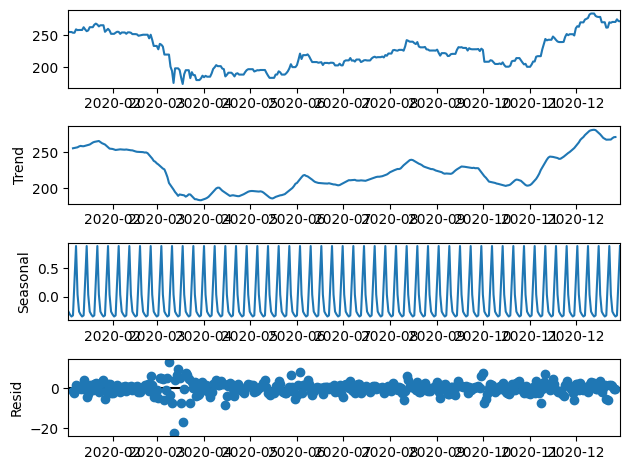

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df_1.asfreq('D').ffill()[['Close']])
result.plot()

train_df_1['Trend'] = result.trend
train_df_1['Seasonal'] = result.seasonal
train_df_1['Residual'] = result.resid

train_df_1

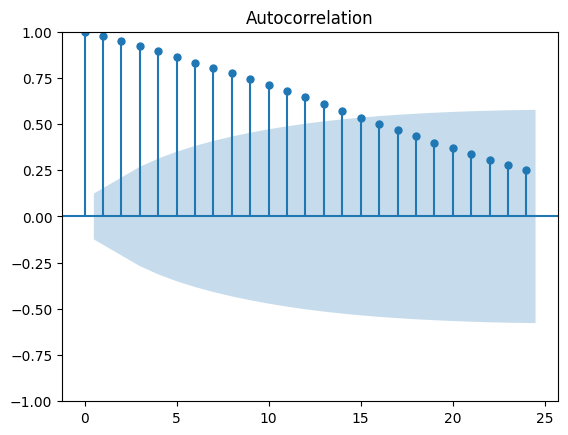

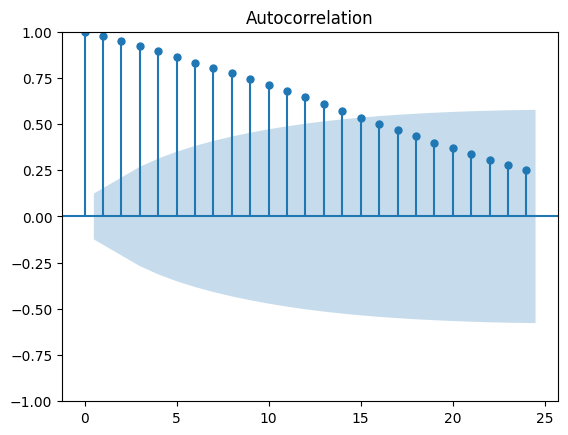

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_df_1['Close'])

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


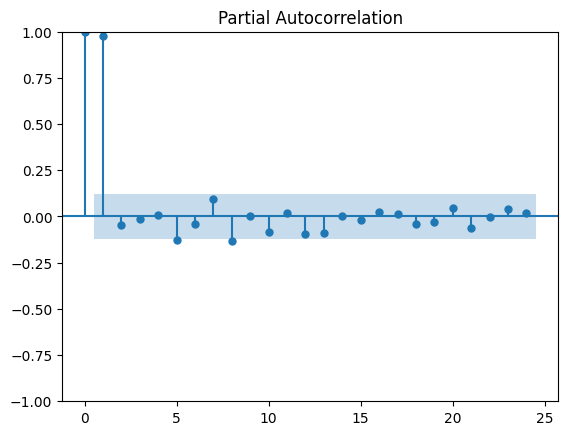

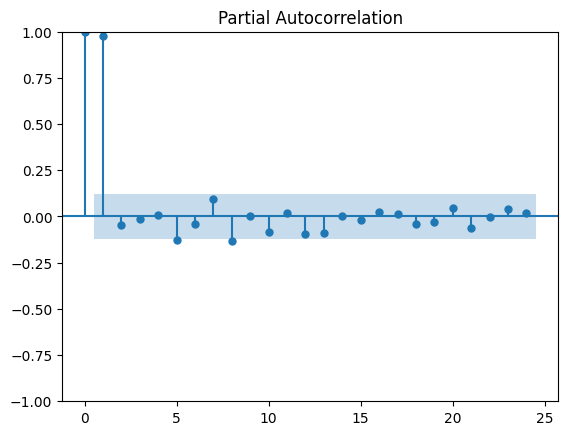

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_df_1['Close'])

1. feature engineering
- add weekly/monthly/quarterly rolling average (or simple moving average; SMA), EMA (exponential MA),
and change based on 'Close' price
* One advantage of the EMA over SMA is that EMA is more responsive to price changes,
which makes it useful for short-term trading.
    SMA assigns equal weights to all historical data points,
    EMA applies higher weights to recent prices

- STL decomposition (Seasonal and Trend decomposition using Loess) to extract some of these components
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(co2_data)
result.plot()

- PACF: the autocorrelation function
* The PACF is an alternative to the ACF. Rather than giving the autocorrelations,
it gives you the partial autocorrelation. This autocorrelation is called partial,
because with each step back in the past, only additional autocorrelation is listed.
This is different from the ACF, as the ACF contains duplicate correlations when variability
can be explained by multiple points in time.
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(co2_data)

you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.


2. normalize scales
* use the StandardScaler, rather than the MinMaxScaler,
The reason is that stock prices are ever-changing, and there are no true min or max values.
It doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to
disastrous results at the end of the day;


3. set evaluation metrics
(e.g., Since stock prices prediction is essentially a regression problem,
 the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %)
 will be our current model evaluation metrics. Both are useful measures of forecast accuracy. )


4. build a prediction model
* When predicting short-term stock prices, it is generally better to focus on more recent data rather than using the data from the entire year. However, it's important to strike a balance between using recent data and having enough historical context. It's recommended to experiment with different time periods and evaluate the performance of your predictions to find the optimal balance.


* LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series.
    It can capture historical trend patterns, and predict future values with high accuracy. 
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571

* Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects.
On top of that, it adds the X: external variables. If you have any variables that could help your model to improve,
you could add them with SARIMAX.

* exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
es = SimpleExpSmoothing(co2_data.co2.values)
es.fit(smoothing_level=0.01)
plt.plot(co2_data.co2.values)
plt.plot(es.predict(es.params, start=0, end=None))
plt.show()

* Reinforcement learning
https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/


5. evaluate model performance


6. based on the final model prediction, recommend BUY, HOLD, SELL decisions for each stock.
(Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.)


7. evaluate on the basis of capital returns (based on the trading decisions).


8. use bollinger bands to measure the system/model's effectiveness

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Candlestick(
    x=train_df_1.index,
    open=train_df_1['Open'],
    high=train_df_1['High'],
    low=train_df_1['Low'],
    close=train_df_1['Close']
    )
    ])

# fig.update_layout(
#     margin=dict(l=30, r=30, t=10, b=10),
#     # paper_bgcolor="LightSteelBlue",
# )

fig.update_layout(
    title=f"{stock_name_1}: Daily OHLC", 
    yaxis_title="Price (USD)",
    width=900,
    height=600)

fig.show()

In [ ]:
# Candlestick Chart and Volume Separately
# Source: https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

from plotly.subplots import make_subplots

# figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# candlestick
fig.add_trace(
    go.Candlestick(
        x=train_df_1.index,
        open=train_df_1.Open,
        high=train_df_1.High,
        low=train_df_1.Low,
        close=train_df_1.Close,
        showlegend=False),
    row=1,
    col=1,
    secondary_y=True
)

# volume
fig.add_trace(
    go.Bar(x=train_df_1.index,
           y=train_df_1["Vol."],
           showlegend=False,
           marker={
               "color": "grey",
           }),
    secondary_y=False,
)

fig.update_layout(title=f"{stock_name_1}: Daily OHLCV",
                  yaxis_title="Price (USD)",
                  width=900,
                  height=600)

fig.show()

if the target is short-term decision, 

bullish patterns -> price likely to rise => buy
bearish patterns -> price likely to fall => sell

If a candlestick pattern doesn’t indicate a change in market direction, it is what is known as a continuation pattern. These can help traders to identify a period of rest in the market, when there is market indecision or neutral price movement. => hold

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

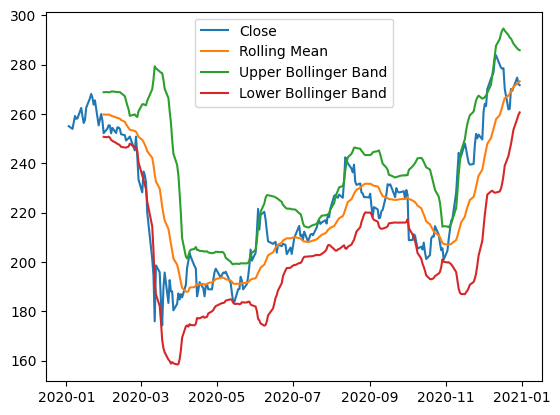

In [ ]:
import matplotlib.pyplot as plt

# Define time period and calculate rolling mean and standard deviation
time_period = 20
rolling_mean = train_df_1['Close'].rolling(window=time_period).mean()
rolling_std = train_df_1['Close'].rolling(window=time_period).std()

# Calculate upper and lower Bollinger Bands
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

# Plot the data and the Bollinger Bands
plt.plot(train_df_1['Close'], label='Close')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(upper_band, label='Upper Bollinger Band')
plt.plot(lower_band, label='Lower Bollinger Band')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load time series data into a pandas DataFrame
# data = pd.read_csv('time_series_data.csv', index_col='date', parse_dates=True)

# Define the independent variable(s) (e.g. other time series data)
independent_variable = train_df_1.loc[:, train_df_1.columns != 'Close']

# Define the dependent variable (i.e. the time series data to be analyzed)
dependent_variable = train_df_1['Close']

# Create the regression model and fit it to the data
model = sm.OLS(dependent_variable, sm.add_constant(independent_variable)).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.814e+04
Date:                Sun, 21 May 2023   Prob (F-statistic):          2.03e-311
Time:                        09:55:06   Log-Likelihood:                -436.05
No. Observations:                 250   AIC:                             884.1
Df Residuals:                     244   BIC:                             905.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3043      0.859      0.354      0.7

In [ ]:
train_df_1['Close']

Date
2021-01-04    272.00
2021-01-05    275.20
2021-01-06    272.93
2021-01-08    283.64
2021-01-11    289.49
               ...  
2021-03-25    286.66
2021-03-26    291.22
2021-03-29    293.30
2021-03-30    293.25
2021-03-31    291.02
Name: Close, Length: 61, dtype: float64

To perform time series regression with multiple independent variables in Python, you can use the VARMAX class from the statsmodels library. This class extends the VAR class to include exogenous variables, allowing you to model the relationship between multiple time series and multiple independent variables.

Here's an example of how to perform time series regression with multiple independent variables in Python using the VARMAX class:

In this example, the time_series_data.csv file contains multiple columns of time series data, and the independent_variable_data.csv file contains multiple columns of independent variable data, both with dates as the index. We load these data into pandas DataFrames, and create a VARMAX model using the VARMAX function from statsmodels. We specify the order of the model (i.e. the number of lags for the time series data and the independent variables) using the order parameter, and include the independent variables using the exog parameter. Finally, we fit the model to the data using the fit method, and print a summary of the VARMAX model results using the summary method.

You can customize the VARMAX model by specifying different parameters, such as the type of error structure (e.g. VARMAX, VARMA, etc.), the method for estimating the model parameters (e.g. maximum likelihood, Bayesian, etc.), and the type of exogenous variables (e.g. deterministic, stochastic, etc.). The statsmodels library provides a wide range of options for VARMAX modeling, so be sure to consult the documentation for more information.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Collect and preprocess data
# df = pd.read_csv('stock_prices.csv')
# # ... preprocess data as necessary ...

# # Feature engineering
# df['moving_avg'] = df['close_price'].rolling(window=5).mean()

# Split data into training and test sets
# train_data = df_1_train.loc[:, 'Price']
# test_data = df_1_test.loc[:, 'Price']

time_period=10
train_data = train_df_1['Close'].rolling(window=time_period).mean().dropna()
test_data = train_df_1['Close'].rolling(window=time_period).mean().dropna()

# Train the model
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Evaluate the model
predictions = model_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data, predictions)
print('MSE:', mse)

# Make predictions
forecast = model_fit.forecast(steps=10)

# Implement the strategy
buy_threshold = forecast.mean() * 0.95
sell_threshold = forecast.mean() * 1.05
# ... implement trading strategy ...


c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MSE: 162.27453271800232


c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
forecast

241    269.484300
242    268.938818
243    268.447568
244    268.005157
245    267.606731
246    267.247916
247    266.924775
248    266.633760
249    266.371678
250    266.135651
Name: predicted_mean, dtype: float64

In [ ]:
train_df_1

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...
2020-12-24,269.32,271.98,272.82,267.13,42610000.0,-0.0029
2020-12-25,270.64,269.97,271.00,268.28,11990000.0,0.0049
2020-12-28,274.70,270.90,275.19,269.73,39040000.0,0.0150


In [ ]:
test_df_1

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,272.00,274.67,276.60,270.61,48920000.0,0.0013
2021-01-05,275.20,272.69,275.70,270.28,45580000.0,0.0118
2021-01-06,272.93,275.94,275.94,271.62,40950000.0,-0.0082
2021-01-08,283.64,275.11,283.99,275.11,88930000.0,0.0392
2021-01-11,289.49,282.86,292.95,279.48,112350000.0,0.0206
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071
